<a href="https://colab.research.google.com/github/tlancaster6/AquaMVS/blob/main/docs/tutorial/notebook.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# End-to-End Reconstruction Tutorial

This tutorial walks through a complete multi-view stereo reconstruction workflow using the AquaMVS Python API applied to real-world data. We start from synchronized multi-camera images and calibration data, run the reconstruction pipeline, and produce a 3D surface mesh. To learn how to generate calibration data, see [AquaCal](https://github.com/tlancaster6/AquaCal)

**Beginners' Note** the python API shown here is designed for users who need fine-grained control and customization capabilities. Start with the CLI, and only turn to the API when necessary. 

By the end of this tutorial, you will have:
- Loaded and inspected a pipeline configuration
- Executed the reconstruction pipeline
- Examined intermediate outputs (depth maps, consistency maps)
- Visualized the fused point cloud
- Exported the final mesh to various formats

## GPU Availability Check

It is highly recommended that you run this notebook (and aquamvs in general) on a GPU-enabled machine or runtime if you want reasonable runtimes. The below cell will check for GPU availability. If you are running locally and it prints false, confirm that your computer has a CUDA-capable GPU and that you followed the pytorch install instructions in the Installation section of the docs. If you are on Colab, check you are using a GPU runtime. 

In [1]:
import torch

print(torch.cuda.is_available())

True


## Setup

Install aquamvs (if not already installed), download the example dataset, and import key modules

In [2]:
# Install AquaMVS (run this cell in Colab; skip locally if already installed)
import importlib.util
import subprocess
import sys

if importlib.util.find_spec("aquamvs") is None:
    subprocess.run(
        [
            sys.executable,
            "-m",
            "pip",
            "install",
            "torch",
            "torchvision",
            "--index-url",
            "https://download.pytorch.org/whl/cpu",
            "-q",
        ],
        check=True,
    )
    subprocess.run(
        [
            sys.executable,
            "-m",
            "pip",
            "install",
            "git+https://github.com/cvg/LightGlue.git@edb2b83",
            "git+https://github.com/tlancaster6/RoMaV2.git",
            "aquamvs",
            "-q",
        ],
        check=True,
    )

In [3]:
import os
import urllib.request
import zipfile
from pathlib import Path

DATASET_URL = "https://zenodo.org/records/18702024/files/aquamvs-example-dataset.zip"
DATASET_DIR = Path("aquamvs-example-dataset")

if not DATASET_DIR.exists():
    print("Downloading example dataset...")
    urllib.request.urlretrieve(DATASET_URL, "aquamvs-example-dataset.zip")
    with zipfile.ZipFile("aquamvs-example-dataset.zip") as zf:
        zf.extractall(DATASET_DIR)
    os.remove("aquamvs-example-dataset.zip")
    print("Done.")
else:
    print(f"Dataset already present at {DATASET_DIR}")

Dataset already present at aquamvs-example-dataset


In [4]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from aquamvs import Pipeline, PipelineConfig

# Enable logging so pipeline stages print progress
logging.basicConfig(level=logging.INFO, format="%(name)s - %(message)s")

# Change into the dataset directory so relative config paths resolve correctly
os.chdir(DATASET_DIR)
CONFIG_PATH = Path("config.yaml")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 1. Load and Inspect Configuration

The pipeline configuration defines all parameters for reconstruction: camera paths, calibration file path, feature matching settings, depth estimation parameters, and output options. When working with the CLI, manual modification of config.yaml files is the primary mode of control.

In [5]:
# Load configuration from YAML
config = PipelineConfig.from_yaml(CONFIG_PATH)

# Inspect key parameters
print(f"Cameras: {list(config.camera_input_map.keys())}")
print(f"Output directory: {config.output_dir}")
print(f"Matcher Type: {config.matcher_type}")
print(f"Pipeline mode: {config.pipeline_mode}")
print(f"Device: {config.runtime.device}")

aquamvs.config - Using default: sparse_matching (all defaults)
aquamvs.config - Using default: dense_matching (all defaults)


Cameras: ['e3v8250', 'e3v829d', 'e3v82e0', 'e3v82f9', 'e3v831e', 'e3v832e', 'e3v8334', 'e3v83e9', 'e3v83eb', 'e3v83ee', 'e3v83ef', 'e3v83f0', 'e3v83f1']
Output directory: ./output
Matcher Type: roma
Pipeline mode: full
Device: cuda


**Expected output:** List of camera names (e.g., `['e3v82e0', 'e3v82e1', ...]`), output directory path, extractor type (`'superpoint'`), pipeline mode (`'full'` or `'sparse'`), and device (`'cpu'` or `'cuda'`).

## 2. Run the Pipeline

The `Pipeline` class provides the primary programmatic interface. Calling `.run()` executes the full reconstruction workflow:

1. **Undistortion**: Apply camera calibration to remove lens distortion
2. **Feature Matching**: Extract and match features across camera pairs (LightGlue or RoMa)
3. **Triangulation**: Compute 3D points from feature correspondences (sparse mode) or...
4. **Plane Sweep Stereo**: Dense depth estimation via photometric cost volume (full mode)
5. **Depth Fusion**: Merge multi-view depth maps into a single point cloud
6. **Surface Reconstruction**: Generate a triangle mesh from the point cloud

This step can take a long time to run, depending on image resolution, number of cameras, and hardware.

In [6]:
import torch

torch.cuda.empty_cache()

# Limit to a single frame for this tutorial
config.preprocessing.frame_start = 0
config.preprocessing.frame_stop = 1

# Initialize pipeline
pipeline = Pipeline(config)

# Run reconstruction (single frame)
pipeline.run()

# Free GPU memory held by the pipeline (RoMa model, etc.)
del pipeline
torch.cuda.empty_cache()

aquamvs.pipeline.builder - Loading calibration from ./calibration.json
aquamvs.pipeline.builder - Found 12 ring cameras, 1 auxiliary cameras (of 12/1 in calibration)
aquamvs.pipeline.builder - Computing undistortion maps
aquamvs.pipeline.builder - Creating projection models
aquamvs.pipeline.builder - Selecting camera pairs
aquamvs.masks - Loaded 13 mask(s) from masks
aquamvs.pipeline.builder - Config saved to output\config.yaml
aquamvs.pipeline.runner - Detected image directory input
aquamvs.io - Detected 5 frames across 13 cameras (image directory input)
aquamvs.pipeline.runner - Processing frames 0 to 1 (step 1)
aquamvs.pipeline.stages.undistortion - Frame 0: undistorting images
aquamvs.pipeline.stages.undistortion - undistortion: 66.0 ms
aquamvs.pipeline.stages.dense_matching - Frame 0: running RoMa v2 dense matching (full mode)
Using cache found in C:\Users\tucke/.cache\torch\hub\facebookresearch_dinov3_adc254450203739c8149213a7a69d8d905b4fcfa
dinov3 - using base=100 for rope new
d

2026-02-20 08:45:46 INFO     romav2.romav2 - romav2:116 in __init__ - RoMa v2 initialized.

aquamvs.features.roma - Matching pair 1/60: e3v829d -> e3v832e
aquamvs.features.roma - Matching pair 2/60: e3v829d -> e3v82e0
aquamvs.features.roma - Matching pair 3/60: e3v829d -> e3v8334
aquamvs.features.roma - Matching pair 4/60: e3v829d -> e3v82f9
aquamvs.features.roma - Matching pair 5/60: e3v829d -> e3v8250
aquamvs.features.roma - Matching pair 6/60: e3v82e0 -> e3v8334
aquamvs.features.roma - Matching pair 7/60: e3v82e0 -> e3v829d
aquamvs.features.roma - Matching pair 8/60: e3v82e0 -> e3v832e
aquamvs.features.roma - Matching pair 9/60: e3v82e0 -> e3v831e
aquamvs.features.roma - Matching pair 10/60: e3v82e0 -> e3v8250
aquamvs.features.roma - Matching pair 11/60: e3v82f9 -> e3v83ef
aquamvs.features.roma - Matching pair 12/60: e3v82f9 -> e3v832e
aquamvs.features.roma - Matching pair 13/60: e3v82f9 -> e3v829d
aquamvs.features.roma - Matching pair 14/60: e3v82f9 -> e3v83ee
aquamvs.features.roma - Matching pair 15/60: e3v82f9 -> e3v8250
aquamvs.features.roma - Matching pair 16/60: e3v8

**Expected output:** Per-stage log messages (undistortion, feature matching, triangulation, depth estimation, fusion, surface reconstruction) followed by `"Pipeline complete"`. You may also see a benign warning about ring cameras missing input if your dataset does not include all cameras from the calibration file.

## 3. Examine Intermediate Results

The pipeline saves intermediate outputs to the output directory, organized by frame. Let's load and visualize depth maps and consistency maps for frame 0.

In [7]:
from aquamvs import load_calibration_data

# Path to frame 0 output
output = Path(config.output_dir) / "frame_000000"

# Load calibration to identify ring cameras (auxiliary cameras don't produce depth maps)
calibration = load_calibration_data(config.calibration_path)
ring_cameras = [c for c in calibration.ring_cameras if c in config.camera_input_map]
cam = ring_cameras[0]
print(f"Ring cameras with input: {ring_cameras}")

Ring cameras with input: ['e3v829d', 'e3v82e0', 'e3v82f9', 'e3v831e', 'e3v832e', 'e3v8334', 'e3v83e9', 'e3v83eb', 'e3v83ee', 'e3v83ef', 'e3v83f0', 'e3v83f1']


### Depth Map

Depth maps represent the distance along each ray from the camera to the water surface. Values are in meters (ray depth, not world Z).

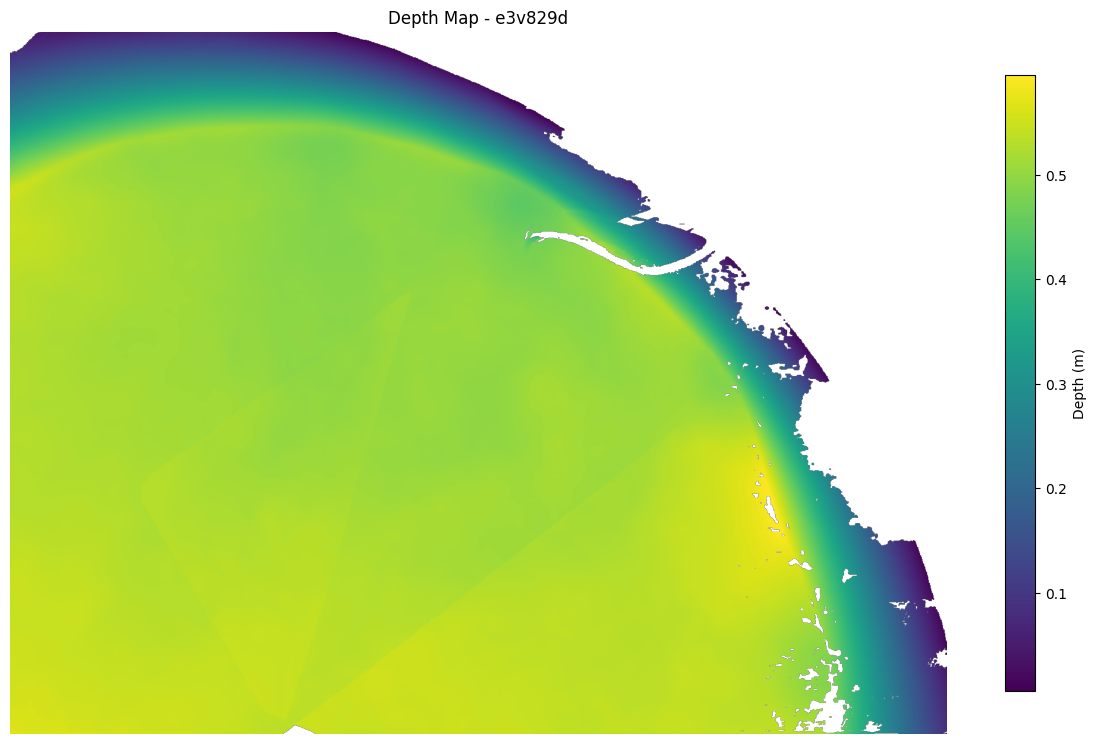

Depth range: 0.006 to 0.595 m
Valid pixels: 1519996 / 1920000 (79.2%)


In [8]:
# Load depth map (saved as NPZ with 'depth' array)
depth_data = np.load(output / "depth_maps" / f"{cam}.npz")
depth = depth_data["depth"]

# Visualize
plt.figure(figsize=(12, 8))
plt.imshow(depth, cmap="viridis")
plt.colorbar(label="Depth (m)", shrink=0.8)
plt.title(f"Depth Map - {cam}")
plt.axis("off")
plt.tight_layout()
plt.show()

# Print statistics
valid_mask = ~np.isnan(depth)
print(f"Depth range: {np.nanmin(depth):.3f} to {np.nanmax(depth):.3f} m")
print(
    f"Valid pixels: {valid_mask.sum()} / {depth.size} ({100 * valid_mask.sum() / depth.size:.1f}%)"
)

### Consistency Map

Consistency maps indicate how many source cameras agree with the reference camera's depth estimate at each pixel. Higher values (warmer colors) indicate more reliable depth.

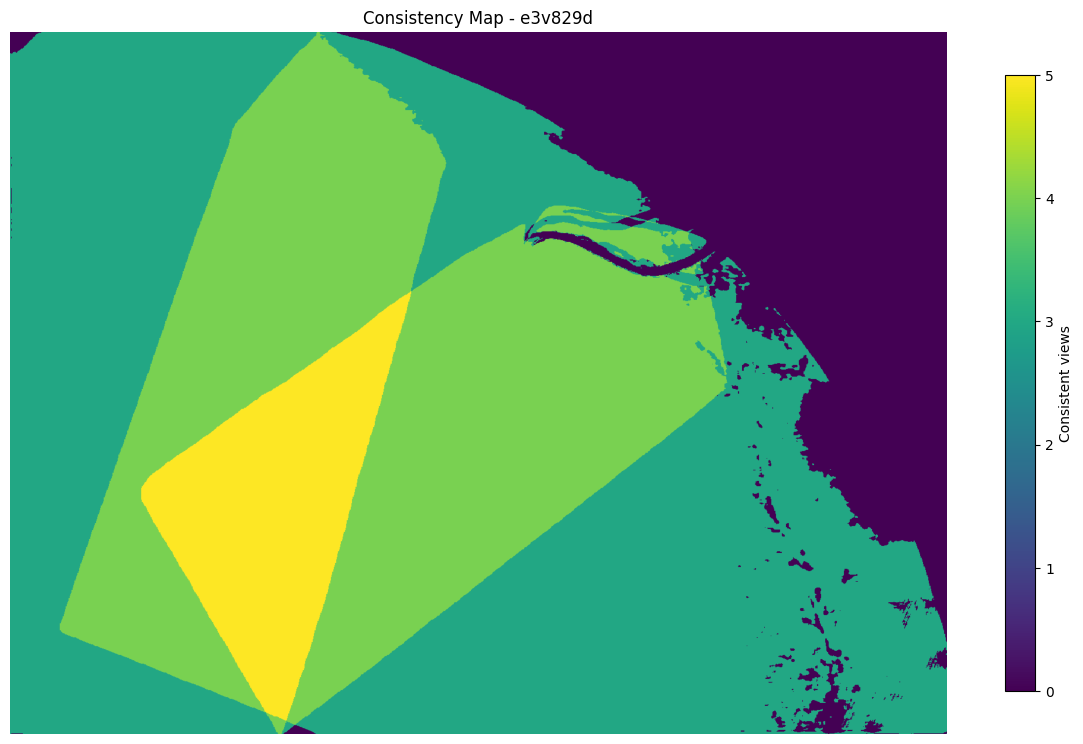

Consistency range: 0 to 5 views
Mean consistency: 3.6 views


In [13]:
# Load consistency map (requires save_consistency_maps: true in config)
consistency_path = output / "consistency_maps" / f"{cam}.npz"
if consistency_path.exists():
    consistency_data = np.load(consistency_path)
    consistency = consistency_data["consistency"]

    # Visualize
    plt.figure(figsize=(12, 8))
    plt.imshow(consistency, cmap="viridis")
    plt.colorbar(label="Consistent views", shrink=0.8)
    plt.title(f"Consistency Map - {cam}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    # Print statistics
    print(
        f"Consistency range: {consistency.min():.0f} to {consistency.max():.0f} views"
    )
    print(f"Mean consistency: {consistency[valid_mask].mean():.1f} views")
else:
    print(
        "Consistency maps not found. Set save_consistency_maps: true in "
        "config.yaml (under runtime:) and re-run the pipeline to generate them."
    )

## 4. Visualize the Fused Point Cloud

The fusion stage merges all camera depth maps into a single 3D point cloud, saved as `fused.ply`.

Point cloud: 12398241 points
Has colors: True
Has normals: True
Bounding box: [1.98694462 1.95052695 0.57405126] m


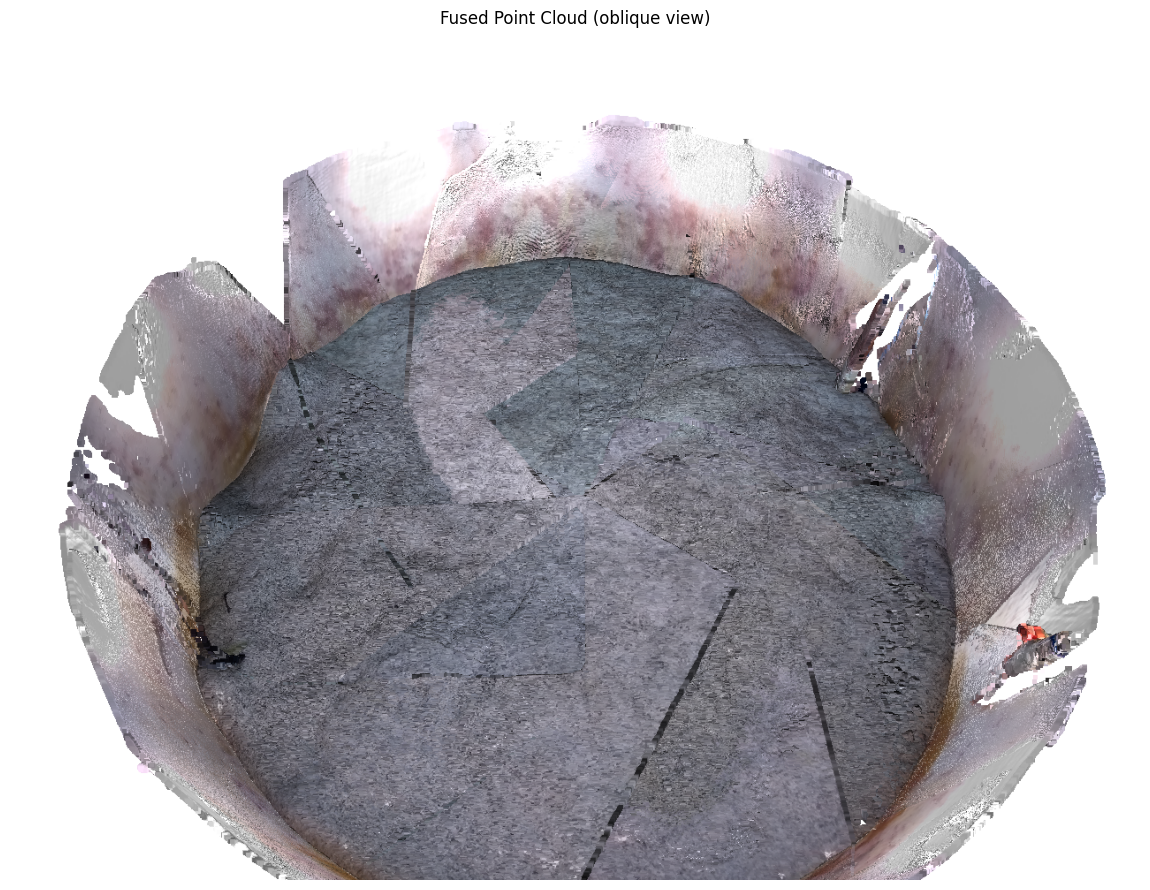

In [14]:
import gc

import open3d as o3d

torch.cuda.empty_cache()
# Load fused point cloud
pcd_path = output / "point_cloud" / "fused.ply"
pcd = o3d.io.read_point_cloud(str(pcd_path))

print(f"Point cloud: {len(pcd.points)} points")
print(f"Has colors: {pcd.has_colors()}")
print(f"Has normals: {pcd.has_normals()}")

# Compute bounds
bbox = pcd.get_axis_aligned_bounding_box()
print(f"Bounding box: {bbox.get_extent()} m")

# Render an oblique view of the point cloud
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False, width=1280, height=960)
vis.add_geometry(pcd)

# Initial render pass to initialize geometry bounds
vis.poll_events()
vis.update_renderer()

# Set oblique viewpoint (looking from above-front-right)
ctr = vis.get_view_control()
ctr.set_front([-0.3, -0.5, -0.8])  # oblique: slightly from front-right, mostly above
ctr.set_up([0, 0, -1])  # Z-down world: -Z is "up" on screen
ctr.set_lookat(np.asarray(bbox.get_center()))
ctr.set_zoom(0.5)

# Second render pass with the updated view
vis.poll_events()
vis.update_renderer()
img = np.asarray(vis.capture_screen_float_buffer(do_render=True)).copy()
vis.destroy_window()

# Free point cloud and OpenGL resources before mesh visualization
del vis, ctr, pcd, bbox
gc.collect()

plt.figure(figsize=(12, 9))
plt.imshow(img)
plt.title("Fused Point Cloud (oblique view)")
plt.axis("off")
plt.tight_layout()
plt.show()

**Note:** The above rendering uses Open3D's offscreen renderer, which requires a display (or virtual framebuffer on headless systems). If this cell fails, you can still inspect the point cloud by opening `fused.ply` directly in MeshLab, CloudCompare, or any PLY viewer.

## 5. Surface Reconstruction and Export

The surface reconstruction stage converts the point cloud into a triangle mesh. The default method is Poisson reconstruction, which produces a watertight mesh.

Mesh: 433168 vertices, 864522 triangles
Has vertex colors: True
Has vertex normals: True


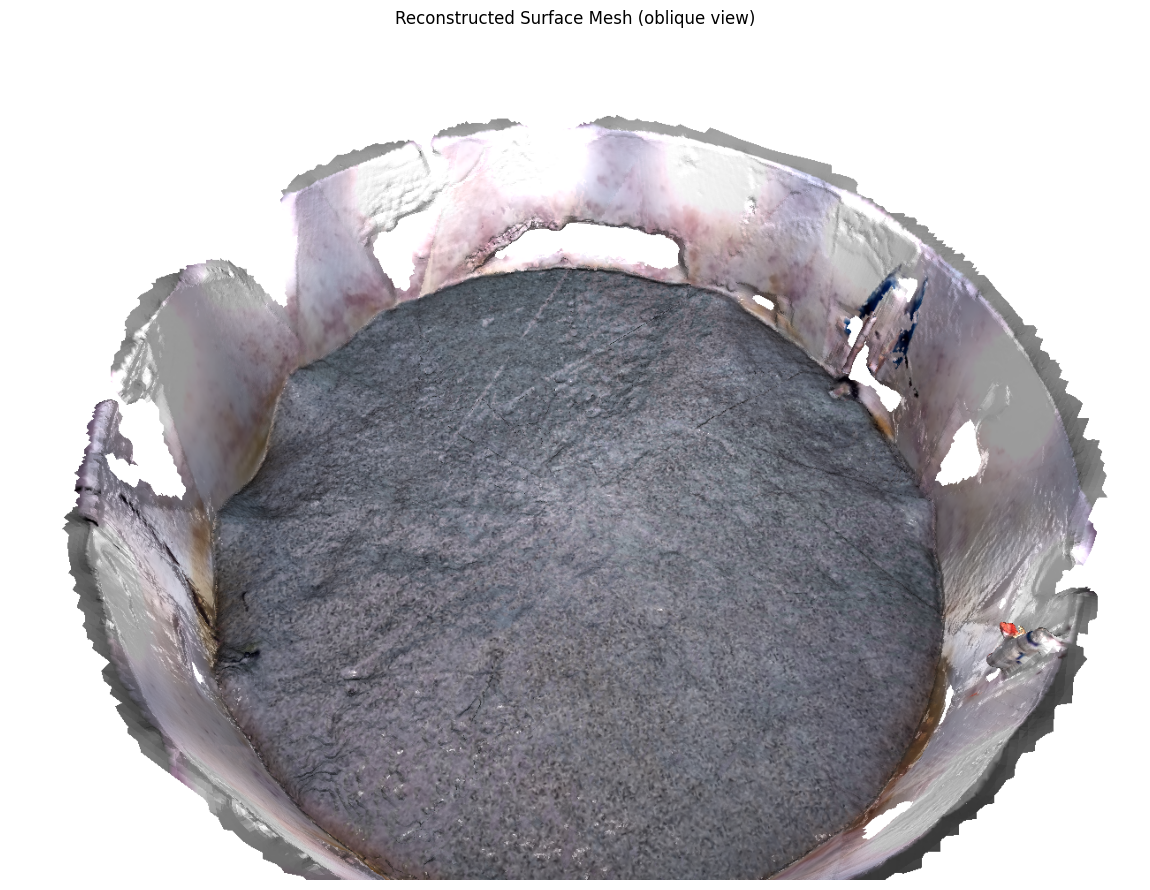

In [15]:
torch.cuda.empty_cache()
# Load reconstructed mesh
mesh_path = output / "mesh" / "surface.ply"
mesh = o3d.io.read_triangle_mesh(str(mesh_path))
mesh.compute_vertex_normals()

print(f"Mesh: {len(mesh.vertices)} vertices, {len(mesh.triangles)} triangles")
print(f"Has vertex colors: {mesh.has_vertex_colors()}")
print(f"Has vertex normals: {mesh.has_vertex_normals()}")

# Render an oblique view of the mesh
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False, width=1280, height=960)
vis.add_geometry(mesh)

# Initial render pass to initialize geometry bounds
vis.poll_events()
vis.update_renderer()

# Set oblique viewpoint (must be set after the first poll/update)
ctr = vis.get_view_control()
mesh_bbox = mesh.get_axis_aligned_bounding_box()
ctr.set_front([-0.3, -0.5, -0.8])
ctr.set_up([0, 0, -1])
ctr.set_lookat(np.asarray(mesh_bbox.get_center()))
ctr.set_zoom(0.5)

# Second render pass with the updated view
vis.poll_events()
vis.update_renderer()
img = np.asarray(vis.capture_screen_float_buffer(do_render=True)).copy()
vis.destroy_window()

del vis, ctr, mesh, mesh_bbox
gc.collect()

plt.figure(figsize=(12, 9))
plt.imshow(img)
plt.title("Reconstructed Surface Mesh (oblique view)")
plt.axis("off")
plt.tight_layout()
plt.show()

### Export to Other Formats

AquaMVS provides an `export_mesh` function to convert meshes to OBJ, STL, GLTF, or GLB formats with optional simplification.

In [16]:
from aquamvs import export_mesh

# Export to OBJ (widely supported, preserves colors)
obj_path = output / "surface.obj"
export_mesh(mesh_path, obj_path)
print(f"Exported to OBJ: {obj_path}")

# Export to STL with simplification (for 3D printing)
stl_path = output / "surface_simplified.stl"
export_mesh(mesh_path, stl_path, simplify=10000)
print(f"Exported simplified mesh to STL: {stl_path}")

# Export to GLB (compact, web-ready)
glb_path = output / "surface.glb"
export_mesh(mesh_path, glb_path)
print(f"Exported to GLB: {glb_path}")

aquamvs.surface - Loading mesh from output\frame_000000\mesh\surface.ply
aquamvs.surface - Loaded mesh: 433168 vertices, 864522 faces
aquamvs.surface - Exporting to output\frame_000000\surface.obj (format: .obj)
aquamvs.surface - Export complete: 864522 faces written to output\frame_000000\surface.obj
aquamvs.surface - Loading mesh from output\frame_000000\mesh\surface.ply
aquamvs.surface - Loaded mesh: 433168 vertices, 864522 faces


Exported to OBJ: output\frame_000000\surface.obj


aquamvs.surface - Simplifying mesh: 864522 faces -> target 10000 faces
aquamvs.surface - Simplification result: 10000 faces
aquamvs.surface - Computing triangle normals for STL export
aquamvs.surface - STL format does not support vertex colors (colors will be lost)
aquamvs.surface - Exporting to output\frame_000000\surface_simplified.stl (format: .stl)
aquamvs.surface - Export complete: 10000 faces written to output\frame_000000\surface_simplified.stl
aquamvs.surface - Loading mesh from output\frame_000000\mesh\surface.ply
aquamvs.surface - Loaded mesh: 433168 vertices, 864522 faces
aquamvs.surface - Exporting to output\frame_000000\surface.glb (format: .glb)


Exported simplified mesh to STL: output\frame_000000\surface_simplified.stl


aquamvs.surface - Export complete: 864522 faces written to output\frame_000000\surface.glb


Exported to GLB: output\frame_000000\surface.glb


## Next Steps

Now that you have completed a basic reconstruction, explore:

- **[CLI Guide](../cli_guide.md)**: Command-line workflow for batch processing
- **[Sample Output](../benchmarks)**: Compare LightGlue and RoMa reconstruction pathways with timing and quality metrics
- **[Troubleshooting Guide](../troubleshooting)**: If you encounter issues, see the troubleshooting guide
- **[Theory](../theory/index.rst)**: Understand the refractive geometry and algorithms
- **[API Reference](../api/index.rst)**: Detailed documentation of all modules and functions

### Configuration Tips

- **Switch matchers**: Set `matcher_type: "lightglue"` for an alternative reconstruction pipeline
- **Adjust depth range**: Modify `reconstruction.depth_min` and `depth_max` to focus on your region of interest
- **Quality vs. speed**: Use `aquamvs init --preset fast` when initializing your configuration for a faster but lower-quality reconstruction
- **Increase quality**: Increase `reconstruction.num_depths` (default: 64) for higher quality at the cost of longer runtime

### Multi-Frame Reconstruction

To process multiple frames, adjust `preprocessing` settings in the config:

```yaml
preprocessing:
  frame_start: 0
  frame_stop: 100  # Process frames 0-99
  frame_step: 10   # Every 10th frame
```

Each frame's outputs will be saved to `output/frame_XXXXXX/`.